<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🍿Netflix</font>](https://www.kaggle.com/c/19jun23jh-netflix/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

### Group 3 Members:
- Vincent Kowalski
- Erik Nyquist
- Kyle Psilopoulos

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
#!pip install -q --upgrade imgaug==0.2.5 > log.txt  # avoids warning/conflict with scipy upgrade
#!pip install -q --upgrade scipy >>log.txt  # upgrades 1.4 to 1.8

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 19jun23jh-netflix        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 19jun23jh-netflix
100% 45.0M/45.0M [00:03<00:00, 13.6MB/s]
Using competition: 19jun23jh-netflix
  teamId  teamName               submissionDate       score    
--------  ---------------------  -------------------  -------  
10602951  Group 9                2023-07-02 00:12:04  0.42990  
10602783  Florian Muellerklein   2023-07-02 02:35:22  0.42490  
10606288  Vincent Kowalski       2023-07-02 06:29:58  0.42270  
10620956  Eric                   2023-07-01 18:53:32  0.42150  
10607335  Group 4                2023-06-30 07:10:08  0.42020  
10608805  yjung2976              2023-07-01 18:30:21  0.41960  
10602607  Team 13                2023-07-01 18:51:11  0.41900  
10580383  Group 5                2023-07-01 19:06:30  0.41870  
10628369  VLynch2                2023-07-02 04:07:54  0.41870  
10607564  Andrew Robbertz        2023-07-01 22:45:46  0.41790  
10615163  Jin C                  2023-07-02 02:12:

In [ ]:
%%time
%%capture
%reset -f
!cp metadata.json METADATA
!pip -q install scikit-surprise
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=1000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 1.93 s, sys: 268 ms, total: 2.2 s
Wall time: 58.6 s


The matrix below contains ratings that users (user id or `uid`) have given to the movies (movie ID or `mid`). It is 85% blank, but the original dataset was 99% sparse (with ~1 rating per user) [&#127910;](https://youtu.be/ImpV70uLxyw). Your task is not to fill the whole matrix, but to impute `NaN` values in `XY_Netflix.csv`, which is an equivalent representation of `XY_Netflix_matrix.csv`. This is a collaborative filtering problem, where observations and features have some implicit relation. Recall that typically we expect independent observations in a sample (unless we have a time series or video of image frames, etc.). Here our model needs to learn and leverage the dependencies from observed movie ratings. Clustering techniques might be more intuitive here. [Truncated SVD](https://scikit-learn.org/stable/modules/decomposition.html#lsa) is also popular. Supervised models can be used as well, if we can build features describing our users (which we would treat as observations). Note that we have no other information on users except what they have ranked (which might suggest the cluster they belong to, which might offer unobserved (latent) features). [&#127910;](https://youtu.be/8wLKuscyO9I) Since users relate to other users through the movies they ranked, this can also be presented as a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph).

In [ ]:
dfMtx = pd.read_csv('XY_Netflix_matrix.csv', low_memory=False); dfMtx

,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
0,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128698,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
f = px.imshow(dfMtx.iloc[:2000,:].T, color_continuous_scale='RdBu_r', aspect='auto');  # movies by users (transposed for visual convenience)
f.update_layout(margin=dict(l=0,r=0,b=0,t=0))

In [ ]:
dfMtx.info()   # note the datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128699 entries, 0 to 128698
Columns: 380 entries, 1 to 380
dtypes: float64(380)
memory usage: 373.1 MB


The dataframe below is another representation of the matrix form above. It lists the `uid`$\times$`mid`locations of the values you need to predict (those with `NaN`) and all other non-zero values in the matrix above.

In [ ]:
df = pd.read_csv('XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions

,uid,mid,rtg
0,1,1,NaN
1,2,2,NaN
...,...,...,...
7402070,49692,126,4.0
7402071,9783,37,1.0


In [ ]:
df.rtg.fillna(0).astype(int).value_counts().to_frame().T   # rating frequencies. 0 represents NaN

,4,3,5,2,1,0
rtg,2451087,2120585,1628122,842056,340222,20000


In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**

## Preprocessing

A few different approaches were taken during preprocessing, sampling and feature enrichment were the primary techniques.

### Data Sampling

At first, model development focused on using the predefined `dfX` from the baseline, that samples observations only based on the `uids` that are needed predictions for Kaggle. This was determined to be the best approach as using the entire `XY_Netflix.csv` file was data intensive and typically exceeded the competition timeline, if not causing an OoM error in Colab.

Sampling on multiple different groups of users and movies was attempted:
-	Grouping users by low, mid, and high average user ratings
-	Grouping movies by low, mid, high movie ratings
-	Grouping on a combined average user/movie rating by low vs. high ratings
-	Grouping by movie genre (or combined genres, e.g. “Action Adventure,” “Scifi Thriller,” etc.)

In testing however, the increase in accuracy seen locally for some of these groupings did not bear out on the Kaggle test set, receiving scores below baseline.


### Feature Enrichment

During model development, we explored enriching the feature set with the data in `movies.csv`. This approach was ultimately abandoned as models tended to perform poorly on the holdout set.

```python
df = pd.merge(dfX, dfMov, on="mid")  # Too much noise
```

Ultimately, the best models used `uid`, `mid`, and `rtg` on the Kaggle set as defined in the baseline.

### Mathematical Imputation

Similar to what is provided in the baseline--where the mean was used--a number of mathematical imputations were experimented with. These included:
- mode
- median
- random weighted (weighted based on relative frequency) values
- constants

In no case did any of these mathematical imputations succeed in improving on the baseline although the median and certain constants did come close.

## **Task 2. Modeling Approach**


## Modeling

Over the course of model development, we tried several approaches.

### SVDS

The first approach was to tune the [`svds`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) model from the baseline, namely the hyperparameter `k` and `iterations` [5]. Below outlines the training loop:

```python
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm


best_k = None
lowest_error = float('inf')
error_log = {}

k_values = range(1, 101)  # k 1-100

for k in tqdm(k_values, desc="K"):
    np.random.seed(0)

    # Copy dfX_est for estimation
    dfX_est_copy = dfX_est.copy()

    for _ in range(5):  # apply truncated SVD approximation a few times
        U, D, Vt = svds(dfX_est_copy.to_numpy(), k=k)  # find k eigenvectors (U,V) and eigenvalues (D)
        dfX_est_copy.loc[1:n, 1:p] = U @ np.diag(D) @ Vt  # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)

    # Create a mask where dfX has non-NaN values
    mask_X = ~np.isnan(dfX.to_numpy())

    # Get non-NaN values
    values_X = dfX.to_numpy()[mask_X]
    values_X_est = dfX_est_copy.to_numpy()[mask_X]

    # Calculate the error on these values
    error = mean_squared_error(values_X, values_X_est)
    error_log[k] = error

    print(f"K: {k} - MSE: {error:0.4f}")

    # Check if this error is lower
    if error < lowest_error:
        lowest_error = error
        best_k = k

    # Now place the original/known ratings back into estimated uid×mid matrix
    mask = ~np.isnan(dfX)  # mask locations of NaN's
    dfX_est_copy[mask] = dfX[mask]  # place original/known ratings back into estimated uid×mid matrix

print(f'Best k: {best_k}, MSE: {lowest_error:0.4f}')
```

When we plot MSE against `k`, we get the following:

![TSNE](https://drive.google.com/uc?id=1oXcpJArvtsfGnR7FFq7dpAU0PPNrVa55)

This suggests that increasing `k` results in lower error between the predicted distribution and the observed distribution. So we set `k=100`.

The next question was to figure out how training iterations improved performance. Compare the distributions of predicted values to observed values for two different iterations, 5 and 10:

![5_iter](https://drive.google.com/uc?id=1KeYyohSLFzO3FppDDOkCPmLQgBzpTkLi)

Distribution after 5 iterations of truncated SVD

![10_iter](https://drive.google.com/uc?id=1UGR422fHQ-7Oej4xSugxBKlnbC9POjQd)

Distribution after 10 iterations of truncated SVD.

We notice that the distribution matches much better with a higher number of iterations. However, this model severely underperformed, resulting in only about 33% accuracy on the Kaggle set. This approach was ultimately abandoned.

### Surprise SVDpp

[Surprise SVDpp](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) proved to be the highest performing model [3]. The challenge with this model was to [tune the hyperparameters](https://www.asc.ohio-state.edu/statistics/dmsl/GrandPrize2009_BPC_PragmaticTheory.pdf) to achieve the best performance while remaining within the time limit [4]. Ultimately, `n_factors=10` and `n_epochs=8` proved to be the highest allowable settings to beat baseline while remaining under the time constraint. Setting `cache-ratings=True` proved to decrease the time required to fit the model, but it increased the memory requirements so adding any samples beyond those necessary could potentially cause memory issues. Under these settings, local test accuracy achieved was `0.4339` in comparison to the Kaggle score of `0.4227`, indicating that the ‘early stopping’ to stay under the time limit proved an effective regularizer as the Kaggle test accuracy difference was only `0.0112`. In analyzing the rating distribution (under the "Code" section), we found that this model predicts a greater amount of 2 and 4 ratings and fewer 3 and 5 ratings in comparison to the baseline model. Outside of the time constraint, running the SGD model fitting to convergence seemingly results in very accurate test predictions (`>90%` accuracy on local testing), but requires `>5` min to run; therefore, the true accuracy of the fully converged model was not tested on the Kaggle set.

### Additional Surprise Library Models

In addition to SVDpp, other algorithms provided by the Surprise library were exprimented with. These include (with summarized findings, relative rankings):
  - SVD (accuracy rank: 4; speed rank: 8)
  - SlopeOne (accuracy rank: 7; speed rank: 10)
  - NMF (accuracy rank: 8; speed rank: 9)
  - NormalPredictor (accuracy rank: 11; speed rank: 1)
  - KNNBaseline (accuracy rank: 2; speed rank: 5)
  - KNNBasic (accuracy rank: 10; speed rank: 6)
  - KNNWithMeans (accuracy rank: 6; speed rank: 4)
  - KNNWithZScore (accuracy rank: 5; speed rank: 7)
  - BaselineOnly (accuracy rank: 3; speed rank: 2)
  - CoClustering (accuracy rank: 9; speed rank: 3)

SVDpp ranked both the most accurate and the slowest.

Besides the SVDpp, the most data was collected on the Surprise SVD algorithm. SVD and its derived algorithms such as SVDpp are most often [cited in the literature](https://www.researchgate.net/publication/228552034_Incremental_singular_value_decomposition_algorithms_for_highly_scalable_recommender_systems) as being most appropriate for this application area [6]. Tests of the SVD algorithm below showed that it produced some of the better models in our experiments.

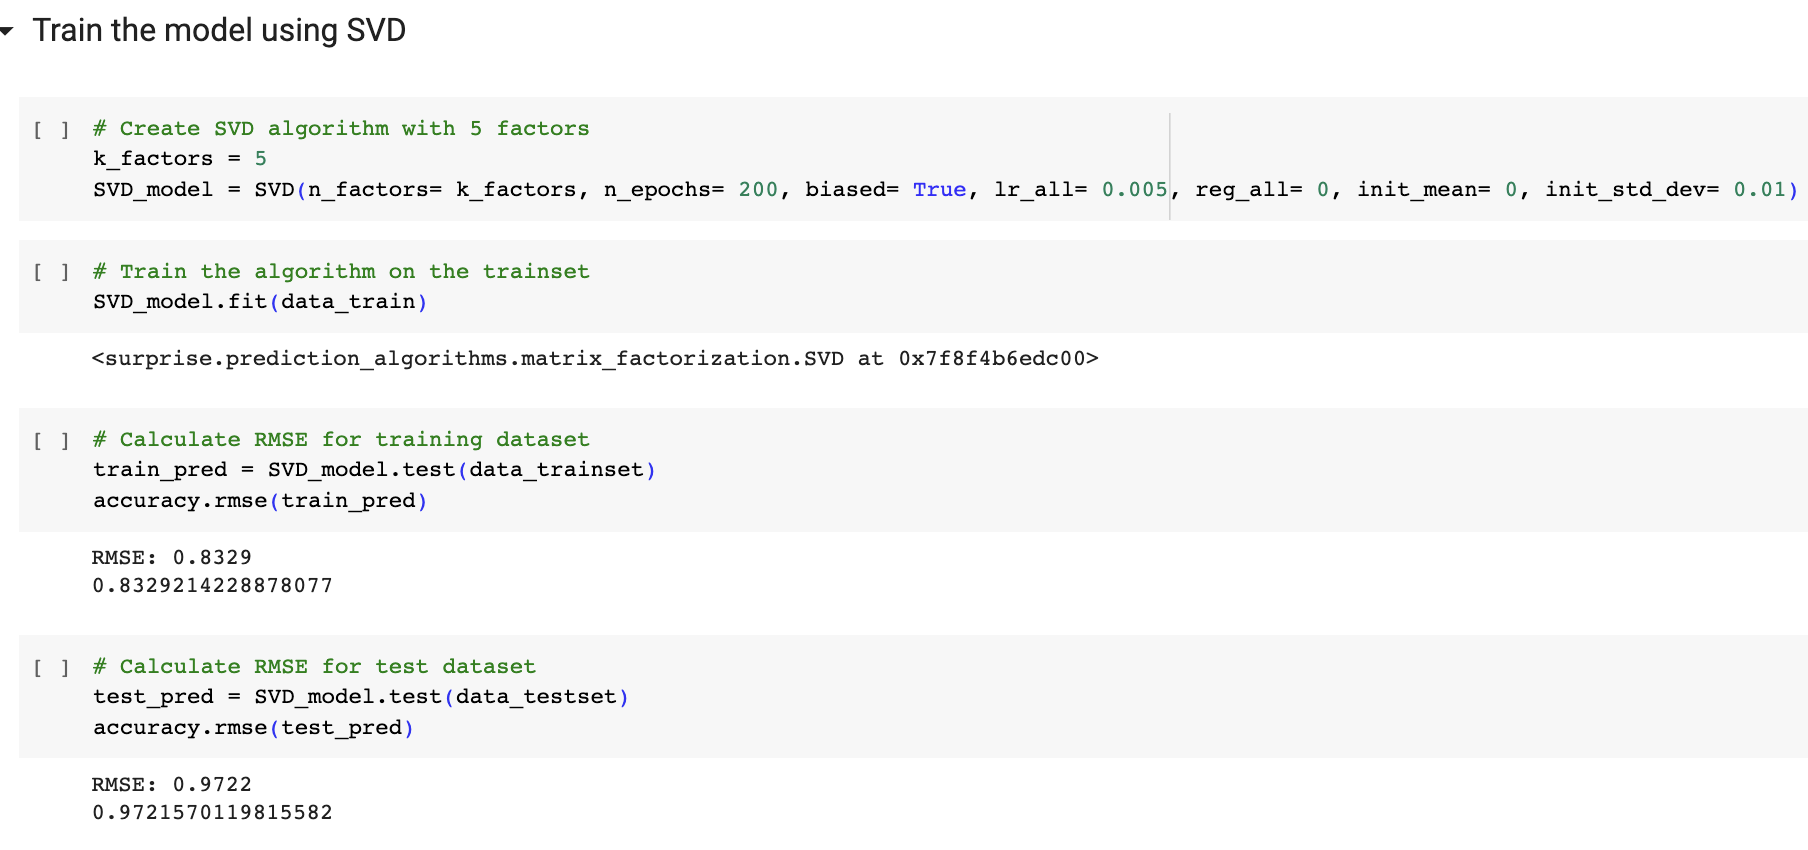

Unfortunately, although the example above produced very good values for RMSE, the model required 16 minutes to train.

### Code
Below contains our code for the Kaggle Competition. Be sure to be in a GPU instance for best performance.

In [ ]:
# Separate training and test sets, drop NaN values from training set
dfK = df[df.rtg!=df.rtg]
df = df.dropna()
dfX = df[df.uid.isin(dfK.uid.unique())]

# Instantiate and train SVDpp model
from surprise import SVDpp, Dataset, Reader, accuracy
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(dfX, reader)
train = data.build_full_trainset()
svdpp = SVDpp(n_factors=10, n_epochs=8, reg_all=0.02, lr_all=0.009, verbose=True, cache_ratings=True, random_state=0)
svdpp.fit(train)

# Convert test set to np.array and predict ratings using trained model
dfK_val = dfK.values
preds = svdpp.test(dfK_val)

# Process predictions for submission
df_preds = pd.DataFrame({'uid': [pred.uid for pred in preds],
                         'mid': [pred.iid for pred in preds],
                         'rtg': [pred.est for pred in preds]})
df_preds = df_preds.round(0).astype(int)
df_preds.index = (df_preds.uid-1)*df_preds.mid.max()+df_preds.mid
df_preds['rtg'] = df_preds['rtg'].clip(1, 5)
df_preds

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7


,uid,mid,rtg
1,1,1,3
382,2,2,5
...,...,...,...
3758583,9892,3,4
6978071,18364,131,4


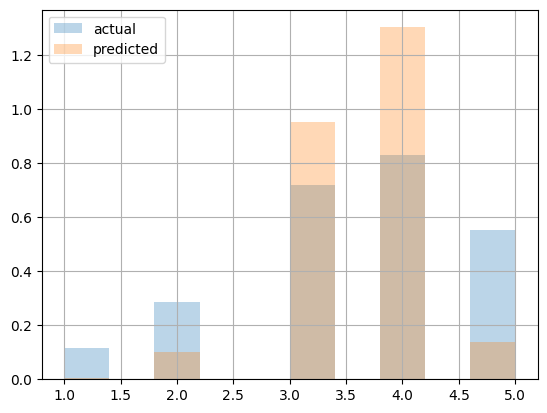

In [ ]:
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = df_preds.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
ToCSV(df_preds[['rtg']].sort_index(), 'MySubmission')

# **References:**

1. Aurélien Géron. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly Media, Inc. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632.

2. Koren, Y., Bell, R., &amp; Volinsky, C. (2009, August). Matrix factorization techniques for recommender systems | IEEE journals ... https://ieeexplore.ieee.org/abstract/document/5197422

3. Matrix Factorization-based algorithms — Surprise 1 documentation. (n.d.). Surprise.readthedocs.io. https://surprise.readthedocs.io/en/stable/matrix_factorization.html

4. Piotte, M., Chabbert, M. (n.d.). The pragmatic theory solution to the Netflix Grand Prize. https://www.asc.ohio-state.edu/statistics/dmsl/GrandPrize2009_BPC_PragmaticTheory.pdf

5. Scipy.sparse.linalg.svds#. scipy.sparse.linalg.svds - SciPy v1.11.1 Manual. (n.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

6. Sarwar, B., et. al., Incremental Singular Value Decomposition Algorithms for Highly Scalable Recommender Systems. https://www.researchgate.net/publication/228552034_Incremental_singular_value_decomposition_algorithms_for_highly_scalable_recommender_systems

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 44 sec


## 💡**Starter Ideas**

1. Tune model **hyperparameters**.
  1. SVD's $k$ might be user-perceived movie genres (perhaps, an average user categorizes movies into just 5 or 50 genres) [🎦](https://youtu.be/sooj-_bXWgk)
1. Try smarter **sampling** from the training set to avoid using all observations (due to time constraint)
  1. Some movies may have consistent high/low ratings and do not distinguish user preferences (just add to runtime)
1. Try SVD on groups (say movie genres) with the largest impact on overall accuracy
1. Try smarter initial imputation, perhaps, conditioned on movie genres or other observed features
1. Try clustering techniques from [SKL](https://scikit-learn.org/stable/modules/clustering.html)
1. Try engineering new features using Movies' data (`movies.csv`)
1. Try supervised approach on clusters or engineered features
1. Try shift/scale ratings. Recall: SVD seeks largest quadratic error from mean without shifting first, like variance does. Since $1^2\ll5^2$, SVD might work better for higher ratings.
  1. Note: the baseline model squeezes predictions towards ratings 3 and 4, which is not the original distribution.
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA. Are there movies that are liked by most viewers?
1. Try Robust PCA (RPC) [🎦](https://www.youtube.com/watch?v=yDpz0PqULXQ), [RPCA Github](https://github.com/dganguli/robust-pca)
1. Find polarized movies and tune for them (like "*Napoleon Dynamite*"). See [&#127910;](https://youtu.be/ImpV70uLxyw)
1. Try KNN [📄](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.596&rep=rep1&type=pdf), [📄](https://scholar.google.com/scholar?q=knn+netflix+prize)
1. Learn more methods to build/use latent representations [🎦](https://youtu.be/n3RKsY2H-NE),  [📄](https://ieeexplore.ieee.org/abstract/document/5197422), [📄](https://scholar.google.com/scholar?q=netflix+prize+challenge), [&#127910;](https://www.youtube.com/results?search_query=netflix+prize+svd), [📄](https://www.aaai.org/Papers/AAAI/2002/AAAI02-029.pdf),